In [ ]:
import sys
sys.path.append("../")

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from loss_dinn_LLM import loss_dinn
import torch.nn.functional as F

In [18]:
covid_cases = pd.read_csv('../data.csv')

S = covid_cases['S']
I = covid_cases['I']
D = covid_cases['D']
R = covid_cases['R']
susceptible = []
infected = []
dead = []
recovered = []
timesteps = []

In [19]:
d1 = covid_cases['S']
d2 = covid_cases['I']
d3 = covid_cases['D']
d4 = covid_cases['R']
d5 = covid_cases['t']

for item in range(len(d5)):
    if item % 1 == 0:
        susceptible.append(d1[item])
        infected.append(d2[item])
        dead.append(d3[item])
        recovered.append(d4[item])
        timesteps.append(d5[item])

x = 180


class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data):
        super(DINN, self).__init__()
        self.N = 6e6
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t), 1))
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []

        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(
            torch.rand(1, requires_grad=True))

        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        self.m1 = torch.zeros((len(self.t), 4))
        self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4))
        self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4))
        self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4))
        self.m4[:, 3] = 1

        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend([self.beta_tilda, self.gamma_tilda])

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)

    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)

    class Net_sidr(nn.Module):
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1 = nn.Linear(1, 200)
            self.fc2 = nn.Linear(200, 100)
            self.out = nn.Linear(100, 4)
            self.out_alpha = nn.Linear(100, 1)

        def forward(self, t_batch):
            x = F.relu(self.fc1(t_batch))
            x = F.tanh(self.fc2(x))
            sidr = self.out(x)
            alpha = self.out_alpha(x)
            return sidr, alpha

    def net_f(self, t_batch):
        sidr_hat, alpha_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,
                                              0], sidr_hat[:, 1], sidr_hat[:, 2], sidr_hat[:, 3]

        # S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        # Unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(alpha_hat / self.N) * S * I) / \
            (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((alpha_hat / self.N) * S * I - self.beta.squeeze()
                            * I - self.gamma * I) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta.squeeze() * I) / \
            (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat, alpha_hat

    def train(self, n_epochs, regul):
        # Train
        print('\nStarting training...\n')

        for epoch in range(n_epochs):
            S_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []
            alpha_pred_list = []

            f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred, alpha_pred = self.net_f(
                self.t_batch)
            self.optimizer.zero_grad()

            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
            alpha_pred_list.append(alpha_pred)
            loss = loss_dinn(self.S_hat[:x], S_pred[:x],
                             self.I_hat[:x], I_pred[:x],
                             self.D_hat[:x], D_pred[:x],
                             self.R_hat[:x], R_pred[:x],
                             f1[:x],
                             f2[:x],
                             f3[:x],
                             f4[:x], I_pred[-1])
            # print("!!!!!!!!!!!!")
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            self.losses.append(loss.item())

            if epoch % 1000 == 0:
                print('\nEpoch ', epoch)

            # Loss + model parameters update
            if epoch % 4000 == 0:
                print('Loss is: ', loss)
                print('Epoch: ', epoch)
                print('dinn.beta', self.beta)
                print('dinn.gamma', self.gamma)
                print(alpha_pred.shape)

        return S_pred_list, I_pred_list, D_pred_list, R_pred_list, alpha_pred_list

In [20]:
# Создаём новый экземпляр модели того же класса и структуры
dinn_loaded = DINN(timesteps, susceptible, infected, dead, recovered)
dinn_loaded.load_state_dict(torch.load(
    '../saved_models/meta_llama_1_dinn_weights.pth'))
# dinn_loaded.eval()  # Переводим в режим оценки, если нужно
S_pred_list, I_pred_list, D_pred_list, R_pred_list, alpha_pred_list = dinn.train(
    10, regul=0.8)


Starting training...



AttributeError: 'DINN' object has no attribute 'optimizer'

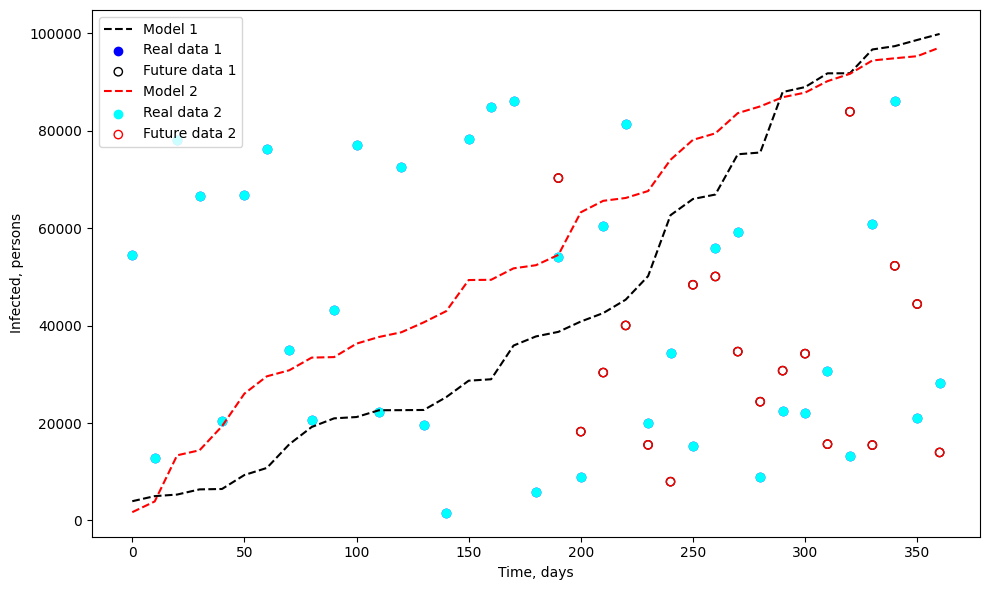

In [ ]:
plt.figure(figsize=(8, 6))

# Первая модель
plt.scatter(timesteps[:x][::10], infected[:x][::10],
            c='blue', alpha=0.5, lw=0.5, label='Real data 1')
plt.scatter(timesteps[x:][::10], infected[x:][::10], c='white',
            edgecolors='black', alpha=0.5, lw=0.5, label='Future data 1')
plt.plot(timesteps, I_pred_list[0].detach().numpy(),
         'black', alpha=0.9, lw=2, label='Model 1', linestyle='dashed')

# Вторая модель
plt.scatter(timesteps2[:x2][::10], infected2[:x2][::10],
            c='cyan', alpha=0.5, lw=0.5, label='Real data 2')
plt.scatter(timesteps2[x2:][::10], infected2[x2:][::10], c='white',
            edgecolors='red', alpha=0.5, lw=0.5, label='Future data 2')
plt.plot(timesteps2, I_pred_list2[0].detach().numpy(),
         'red', alpha=0.9, lw=2, label='Model 2', linestyle='dashed')

plt.xlabel("Time, days")
plt.ylabel("Infected, persons")
plt.legend()
plt.tight_layout()
plt.savefig("./results/two_models_infected_persons.png", dpi=300)
plt.show()